In [1]:
from dm_control import mjcf,mujoco
import PIL.Image

In [2]:
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

%matplotlib inline

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython import display
import PIL.Image

from tempfile import NamedTemporaryFile
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    video=anim.to_html5_video()

    html = display.HTML(video) 
  
    # draw the animation 
    display.display(html)

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

In [3]:
sort_task=mjcf.RootElement(model='sort_task')
sort_task.compiler.angle="radian"
sort_task.compiler.autolimits="true"

sort_task.visual.headlight.diffuse="0.6 0.6 0.6"
sort_task.visual.headlight.ambient="0.1 0.1 0.1"
sort_task.visual.headlight.specular="0 0 0"
sort_task.visual.__getattr__('global').azimuth="0"
sort_task.visual.__getattr__('global').elevation="-30"
sort_task.visual.__getattr__('global').offwidth="1000"
sort_task.visual.__getattr__('global').offheight="1000"
sort_task.visual.quality.shadowsize="4096"

light_wood_texture=sort_task.asset.add('texture',file='/home/vignesh/robot-collab_vig/rocobench/envs/assets/objects/textures/light-wood.png',type="2d",name='tex-light-wood')
light_wood=sort_task.asset.add('material',name='light-wood',reflectance=0.2,texrepeat="15 15",texture='tex-light-wood',texuniform='true')
chequered = sort_task.asset.add('texture', type='2d', builtin='checker', width=300, height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
groundplane = sort_task.asset.add('material', name='grid', texture=chequered, texrepeat=[2, 2], reflectance=.2)

In [4]:
sort_task.worldbody.add('light',pos="0 0 1.5",dir="0 0 -1",directional="true")
sort_task.worldbody.add('geom',name="floor",pos="0 0 -0.5",size="0 0 0.05", type="plane",material=groundplane)
#panda=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/panda.xml')
#sort_task.worldbody.attach(panda)
table_body=sort_task.worldbody.add('body',name='table',pos='0 0.5 0')
table_body.add('geom',name='table_collision',pos='0 0 0.1',size='1.6 0.4 0.05', type='box', group='3', friction='1 0.5 0.0001',rgba='1 1 1 1')

table_top_body=table_body.add('body',name='table_top',pos='0 0 0.1')
table_top_body.add('geom',name='table_top',size='1.6 0.4 0.05',type='box',conaffinity='0',contype='0', group='1',rgba='1 1 1 1')

robot1_site=sort_task.worldbody.add('site',name='robot1',pos='-0.5 -0.05 0.1')
robot2_site=sort_task.worldbody.add('site',name='robot2',pos='-0.3 1.05 0.1',euler='0 0 3.14159')
#robot3_site=sort_task.worldbody.add('site',name='robot3',pos='-0.2 1.05 0.3',euler='0 0 3.14159')
robot1=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/panda.xml')
robot1.model='panda1'
robot2=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/panda.xml')
robot2.model='panda2'

#robot3=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e_robotiq/ur5e_robotiq_full.xml')
#robot3.model='ur5e'

robot1_site.attach(robot1)
robot2_site.attach(robot2)
#robot3_site.attach(robot3)
#table_body.add('geom',name='table_left',pos='-1.63 0 1', size='0.02 1.6 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_right',pos='1.63 0 1', size='0.02 1.6 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_front',pos='0 1.63 1', size='1.7 0.02 1.5', rgba='1 1 1 0', type='box')
#table_body.add('geom',name='table_back',pos='0 -1.63 1', size='1.7 0.02 1.5', rgba='1 1 1 0', type='box')

sort_task.worldbody.add('camera', mode="fixed", name='face_panda1', pos="0.062 -2.806 0.768", xyaxes="1.000 0.009 -0.000 0.001 -0.131 0.991")
sort_task.worldbody.add('camera', mode="fixed", name='face_panda2', pos="0.084 3.711 0.772", xyaxes="-1.000 0.016 0.000 0.002 0.111 0.994")
sort_task.worldbody.add('camera', mode="fixed", name='top_cam', pos="-0.001 0.652 2.057", xyaxes="-1.000 -0.000 -0.000 0.000 -1.000 0.019")
sort_task.worldbody.add('camera', mode="fixed", name='right_cam', pos="1.873 0.605 0.926", xyaxes="0.014 1.000 0.000 -0.242 0.003 0.970")
sort_task.worldbody.add('camera', mode="fixed", name='left_cam', pos="-1.873 0.605 0.926", xyaxes="-0.000 -1.000 0.000 0.177 -0.000 0.984")
sort_task.worldbody.add('camera', name='teaser', pos="2.675 -0.747 1.997", xyaxes="0.496 0.869 -0.000 -0.429 0.245 0.869")
sort_task.worldbody.add('camera', name='video', pos="1.957 -0.281 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

MJCF Element: <camera name="video" class="/" pos="1.9570000000000001 -0.28100000000000003 1.7310000000000001" xyaxes="0.48699999999999999 0.874 0 -0.5 0.27800000000000002 0.81999999999999995"/>

In [5]:
#bin_body1=table_top_body.add('body',name='bin1',pos='-0.5 0 0.05')
#bin_body1.add('geom',name='bottom1',type='box',size='0.35 0.2 0.02',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='front1',type='box',pos='0 0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='back1',type='box',pos='0 -0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='right1',type='box',pos='0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body1.add('geom',name='left1',type='box',pos='-0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')

#box=sort_task.worldbody.add('body',name='black_box',pos='0 0.5 0.37')
#box.add('joint',type='free',name='box_free')
#box.add('body',name='box_top',pos='0 0 0.03')
#box.add('body',name='box_bottom',pos='0 0 -0.03')
#box.add('site',name='box_top',type='sphere',pos='0 0 0.03')
#box.add('site',name='box_bottom',type='sphere',pos='0 0 -0.03')
#box.add('geom',name='box_collision',type='box',size='0.1 0.1 0.3',rgba='0 0 0 1',group=3)
#box.add('geom',name='box_visual',type='box',size='0.1 0.1 0.3',rgba='.85882352 1 0.2 1',group=0)
#bin_body2=table_top_body.add('body',name='bin2',pos='0.5 0 0.05')
#bin_body2.add('geom',name='bottom2',type='box',size='0.35 0.2 0.02',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='front2',type='box',pos='0 0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='back2',type='box',pos='0 -0.2 0.1',size='0.35 0.02 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='right2',type='box',pos='0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
# bin_body2.add('geom',name='left2',type='box',pos='-0.35 0 0.1',size='0.02 0.2 0.06',friction="1 0.005 0.0001",material='light-wood')
#bin_body=sort_task.worldbody.add('body', name="bin", pos="0.45 0.5 0.16")
#bin_inside_body=bin_body.add('body', name="bin_inside", pos="0 0 0")
#bin_inside_body.add('geom', name="bin_inside_bottom", pos="0 0 0", size="0.35 0.2 0.02", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_front", pos="0 0.2 0.03", size="0.35 0.01 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_back", pos="0 -0.2 0.03", size="0.35 0.01 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood")
#bin_inside_body.add('geom', name="bin_inside_right", pos="0.38 0 0.03", size="0.01 0.18 0.06", type="box", group="3", friction="1 0.005 0.0001", rgba="1 0 0 0")
#bin_inside_body.add('geom', name="bin_inside_left", pos="-0.38 0 0.03", size="0.01 0.18 0.06", type="box", group="3", friction="1 0.005 0.0001", rgba="1 0 0 0" )

#bin_body.add('geom', name="bin_right", pos="0.35 0 0.03", size="0.01 0.2 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood", margin="0.01")
#bin_body.add('geom', name="bin_left", pos="-0.35 0 0.03", size="0.01 0.2 0.06", type="box", group="3", friction="1 0.005 0.0001", material="light-wood", margin="0.01")

In [6]:
#sort_task.contact.add('pair', name="milk_panda", geom1="panda1/panda_hand_collision", geom2="box_collision", margin="0.05")
#sort_task.equality.add('weld',name='panda1_top',body1='box_top',body2='panda1/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='panda1_bottom',body1='box_bottom',body2='panda1/panda_palm',relpose='0 0 0 1 0 0 0',active='false')

#sort_task.equality.add('weld',name='ur5e_top',body1='box_top',body2='ur5e/robotiq_tip',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_bottom',body1='box_bottom',body2='ur5e/robotiq_tip',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_top',body1='box_top',body2='ur5e/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
#sort_task.equality.add('weld',name='ur5e_bottom',body1='box_bottom',body2='ur5e/panda_palm',relpose='0 0 0 1 0 0 0',active='false')
panda_qpos0='0 0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04'
ur5_qpos0='0 -1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0 0 0 0 0 0 0 0'
box_qpos0='-0.5 0.5 0.22 0 0 0 0'
panda_ctrl0='0 0 0 0 -1.57079 0 1.57079 -0.7853 255'
ur5_ctrl0='0 1.5708 -1.5708 1.5708 -1.5708 -1.5708 0 0'
#sort_task.keyframe.add('key',name='home',qpos=panda_qpos0+' '+panda_qpos0, ctrl=panda_ctrl0+' '+panda_ctrl0)
sort_task.keyframe.add('key',name='home',qpos='-0.34602755  0.63447365  0.36195947  0.42970204 -1.69805676 -0.16486512  2.02462058  1.8971456   0.04001872  0.03998128  -0.41486947 0.59703017  0.31969344  0.50699116 -1.77033131  -0.17248333  2.04637695 -1.19477207  0.04001872  0.03998128', ctrl=' -0.34602755 0.63447365  0.36195947  0.42970204 -1.69805676 -0.16486512  2.02462058  1.8971456 255 -0.41486947 0.59703017  0.31969344  0.50699116 -1.77033131 -0.17248333 2.04637695 -1.19477207 255')
sort_task.keyframe.add('key', name='middle', qpos='0.4543726   0.36085266  0.75668102  0.5995547  -1.17010745 -0.40597763 1.79508921  1.70958162  0.03993711  0.0400012  -0.41486947  0.59703017 0.3275669   0.50556413 -1.77660573 -0.17278512  2.04523767 -1.1947719 0.04000126  0.03993385', ctrl='4.54372615e-01  3.60852659e-01  7.46300340e-01  6.02532744e-01 -1.16414058e+00 -4.05662984e-01  1.79620075e+00  1.70958185e+00 2.55000000e+02 -4.14869470e-01  5.97030170e-01  3.19693440e-01 5.06991160e-01 -1.77033131e+00 -1.72483330e-01  2.04637695e+00 -1.19477207e+00  2.55000000e+02')

MJCF Element: <key name="middle" qpos="0.45437260000000002 0.36085265999999999 0.75668102000000004 0.5995547 -1.1701074499999999 -0.40597762999999998 1.79508921 1.70958162 0.039937109999999998 0.040001200000000001 -0.41486947000000002 0.59703017000000003 0.32756689999999999 0.50556413 -1.77660573 -0.17278511999999999 2.0452376700000001 -1.1947719000000001 0.040001259999999997 0.03993385" ctrl="0.45437261499999998 0.36085265900000002 0.74630034000000001 0.60253274400000001 -1.16414058 -0.405662984 1.7962007499999999 1.70958185 255 -0.41486947000000002 0.59703017000000003 0.31969344 0.50699116 -1.77033131 -0.17248332999999999 2.04637695 -1.19477207 255"/>

In [7]:
print(sort_task.to_xml_string())
f = open("task_handover.xml", "w")
f.write(sort_task.to_xml_string())
f.close()


<mujoco model="sort_task">
  <compiler autolimits="true" angle="radian"/>
  <option integrator="implicit"/>
  <visual>
    <global azimuth="0" elevation="-30" offwidth="1000" offheight="1000"/>
    <quality shadowsize="4096"/>
    <headlight ambient="0.10000000000000001 0.10000000000000001 0.10000000000000001" diffuse="0.59999999999999998 0.59999999999999998 0.59999999999999998" specular="0 0 0"/>
  </visual>
  <default>
    <default class="/"/>
    <default class="panda1/">
      <default class="panda1/panda">
        <material specular="0.5" shininess="0.25"/>
        <joint axis="0 0 1" range="-2.8973 2.8973" armature="0.10000000000000001" damping="15"/>
        <general ctrlrange="-2.8973 2.8973" forcerange="-87 87" dyntype="none" biastype="affine"/>
        <default class="panda1/finger">
          <joint type="slide" axis="0 1 0" range="0 0.040000000000000001"/>
        </default>
        <default class="panda1/visual">
          <geom type="mesh" contype="0" conaffinity="0" grou

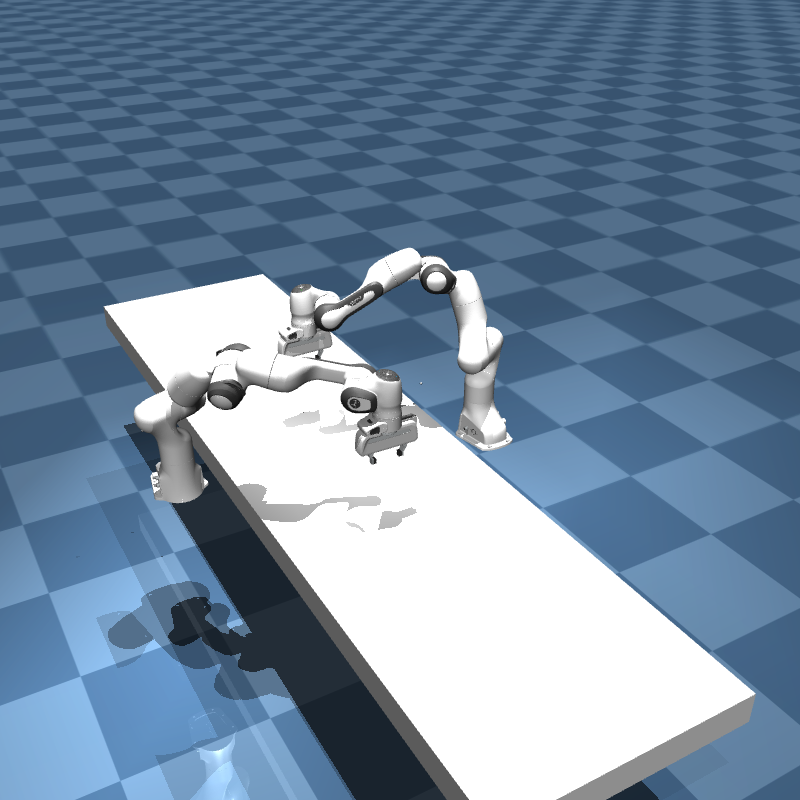

In [8]:
physics=mjcf.Physics.from_mjcf_model(sort_task)
physics.reset(1)
#final_physics=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e/ur5e_robotiq_full.xml')
pixels=physics.render(width=800,height=800,camera_id=5)

ctrl_shape=physics.data.ctrl.shape
PIL.Image.fromarray(pixels)
#print(physics.named.data.qpos)
#print(physics.data.qvel.shape)



In [19]:
physics.data.qpos

array([ 0.4543726 ,  0.36085266,  0.75668102,  0.5995547 , -1.17010745,
       -0.40597763,  1.79508921,  1.70958162,  0.03993711,  0.0400012 ,
       -0.41486947,  0.59703017,  0.3275669 ,  0.50556413, -1.77660573,
       -0.17278512,  2.04523767, -1.1947719 ,  0.04000126,  0.03993385])

In [9]:
%reload_ext autoreload
%autoreload 2
from dm_control import mujoco,viewer
from dm_control.mujoco.wrapper.core import MjvOption
from dm_control.mujoco.wrapper.mjbindings import enums
from rocobench import PlannedPathPolicy, LLMPathPlan, MultiArmRRT
from rocobench.envs import SimRobot
from rocobench import PlannedPathPolicy, LLMPathPlan, MultiArmRRT
from rocobench.envs.constants import PANDA_CONSTANTS
from rocobench.envs.constants import UR5E_ROBOTIQ_CONSTANTS
import copy
from rocobench.subtask_plan import LLMPathPlan
from rocobench.envs.env_utils import Pose



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
target_body='black_box'
target_body_top='box_top'
target_body_bottom='box_bottom'

def home_pose(physics,robots):
    # for key,value in robots.items:
    #     continue
    # qpos0=[0., 0., 0., -1.57079, 0, 1.57079, -0.7853,0]
    # ctrl0=[0, 0, 0, -1.57079, 0, 1.57079, -0.7853,0]
    # qpos=physics.data.qpos.copy()
    # qpos[panda1.joint_idxs_in_qpos]=np.array(qpos0)
    # qpos[ur5e.joint_idxs_in_qpos]=np.array(qpos0)
    # with physics.reset_context():
    #     physics.data.qpos=qpos
    #     physics.data.qvel=np.zeros_like(physics.data.qvel)
    #     physics.data.ctrl[panda1.joint_idxs_in_ctrl]=ctrl0
    #     physics.data.ctrl[panda2.joint_idxs_in_ctrl]=ctrl0
    #     physics.step()
    # return physics
    
    physics.reset(0)
    return physics

def append_panda_names(name,panda_constants):
    constants = dict()
    constants["name"] = name
    for key, value in panda_constants.items():
        #print(key)
        if (key=='name') :
            continue
        if key == "actuator_info":
            constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif isinstance(panda_constants[key],str):
            constants[key]=name+'/'+value
        else:
            constants[key] = [name + "/" + x for x in value]

    return constants

def append_ur5e_names(name,ur5e_constants):
    constants = dict()
    constants["name"] = name
    for key, value in ur5e_constants.items():
        #print(key)
        if (key=='name') :
            continue
        if key == "actuator_info":
            constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif isinstance(ur5e_constants[key],str):
            constants[key]=name+'/'+value
        else:
            constants[key] = [name + "/" + x for x in value]

    return constants

def append_robot_names(name, constants):
    result = dict()
    result["name"] = name
    for key, value in constants.items():
        #print(key)
        if key=='name':
            continue

        if key == "actuator_info":
            result[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif key == "mesh_to_geoms":
            result[key] = {x: [name + "/" + y for y in z] for x, z in value.items()}

        elif isinstance(constants[key],str):
            result[key]= name+'/'+value
        else:
            result[key] = [name + "/" + x for x in value]

    return result

ur5e_constants = append_panda_names("ur5e",UR5E_ROBOTIQ_CONSTANTS)

#ur5e=SimRobot(physics=physics,use_ee_rest_quat=False,**ur5e_constants)
panda1_constants = append_robot_names("panda1",PANDA_CONSTANTS)
panda2_constants = append_robot_names("panda2",PANDA_CONSTANTS)

panda1=SimRobot(physics=physics,use_ee_rest_quat=False,**panda1_constants)
panda2=SimRobot(physics=physics,use_ee_rest_quat=False,**panda2_constants)
robots={'panda1':panda1,'panda2':panda2}
#print(panda1.joint_idxs_in_ctrl)

In [11]:
target_pose1=np.array([-0.5,0,0])
target_pose=np.array([-0.5,0.1,0])
target_pose1[2]+=0.1
print(target_pose1)
target_pose2=target_pose.copy()

target_pose2[0]=-1*target_pose2[0]
target_pose2[2]=0.5
print(target_pose1)
print(target_pose2)
#physics.named.data.xmat[target_body_top]
target_quat=np.array([ 0, 1, 0, 0.0])
result1=panda1.solve_ik(physics,target_pos=target_pose,target_quat=target_quat)
result2=panda2.solve_ik(physics,target_pos=target_pose2)
ctrl1=panda1.map_qpos_to_joint_ctrl(result1.qpos)
ctrl2=panda1.map_qpos_to_joint_ctrl(result2.qpos)
#ctrl2=np.random.random(7)
print(result1.qpos)
print(ctrl1)

[-0.5  0.   0.1]
[-0.5  0.   0.1]
[0.5 0.1 0.5]


AttributeError: 'NoneType' object has no attribute 'qpos'

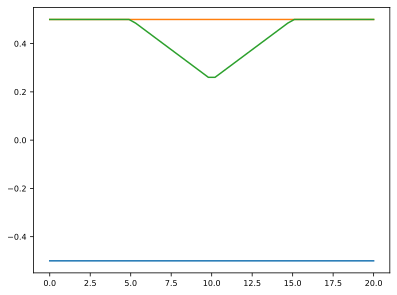

In [75]:
def traj(t):
  #t+=15
  if t<5:
    return np.array([-0.5,0.5,0.5])
  elif t>=5 and t<=10:
    return np.array([-0.5,0.5,0.5*(2-t/5)+0.25*(t/5-1)])
  elif t>10 and t<=15:
    return np.array([-0.5,0.5,0.25*(3-t/5)+0.5*(2*t/10-2)])
  else:
    return np.array([-0.5,0.5,0.5])
ts=np.linspace(0,20)
ys=[traj(t) for t in ts]
plt.plot(ts,ys)

In [217]:
frames = []
ctrls=[]
duration=5
framerate=20
control_rate=0.1
physics.reset()  # Reset state and time

while physics.data.time < duration:
  #target_pose=physics.named.data.xpos[target_body_top]
  #result=panda1.solve_ik(physics,target_pos=target_pose)
  #ctrl=panda1.map_qpos_to_joint_ctrl(result.qpos)
  t0=physics.data.time
  target_pose=traj(physics.data.time)
  #print(target_pose)
  result1=panda1.solve_ik(physics,target_pos=target_pose,target_quat=target_quat)
  result2=panda2.solve_ik(physics,target_pos=np.array([0.5,0.5,0.3]))
  ctrl1=panda1.map_qpos_to_joint_ctrl(result1.qpos)
  ctrl2=panda1.map_qpos_to_joint_ctrl(result2.qpos)
  ctrl=np.concatenate((ctrl1['ctrl_vals'],[0],ctrl2['ctrl_vals'],[0]))
  physics.data.ctrl=ctrl
  #print(ctrl)
  while physics.data.time-t0<0.1:
  #print(physics.data.ctrl)
    physics.step()
    if len(frames) < physics.data.time * framerate:
      pixels = physics.render(width=800,height=800)
      frames.append(pixels)
display_video(frames, framerate)

AttributeError: 'NoneType' object has no attribute 'qpos'

Loading...:   0%|          | 0/1 [00:00<?, ?it/s]

[array([-0.08187176,  0.38653017,  0.0567788 ])]


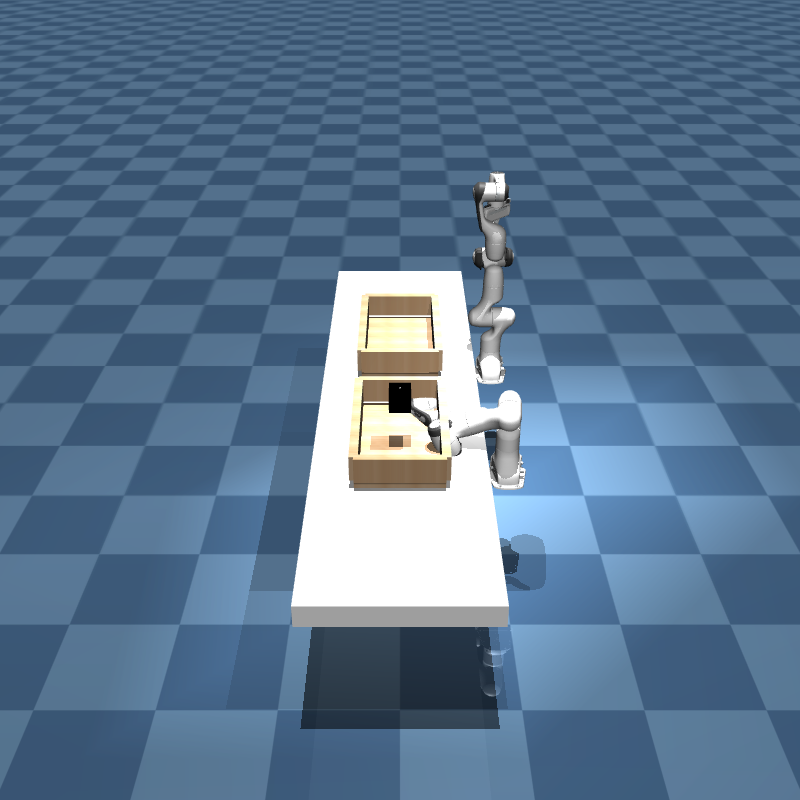

In [57]:
from tqdm import tqdm
physics.reset() 
# state=np.concatenate((result1.qpos,np.zeros(18)))
# with physics.reset_context():
#     physics.data.qpos=result1.qpos
#     physics.data.qvel=np.zeros_like(result1.qpos)
#     physics.step()
#     pixels=physics.render(width=800,height=800)

# ctrl_shape=physics.data.ctrl.shape
# print(np.linalg.norm(physics.named.data.site_xpos['panda1/ee']-target_pose))
# #PIL.Image.fromarray(pixels)

target_poses=[]
dists=[]
for i in tqdm (range (1), desc="Loading..."):
    
    target_pose=np.array([np.random.uniform(-0.7,-0.3),np.random.uniform(0.1,0.9),np.random.uniform(0,0.5)])
    target_poses.append(target_pose)
    target_quat=np.array([ 0, 1, 0, 0.0])
    result1=panda1.solve_ik(physics,target_pos=target_pose,target_quat=target_quat)
    if result1 is not None:
        physics.data.qpos=result1.qpos
        physics.data.qvel=np.zeros_like(physics.data.qvel)
        physics.step()
        dists.append(np.linalg.norm(physics.named.data.site_xpos['panda1/ee']-target_pose))
        pixels=physics.render(width=800,height=800)
        
        break
    else:
        dists.append(-1)
print(target_poses)
PIL.Image.fromarray(pixels)

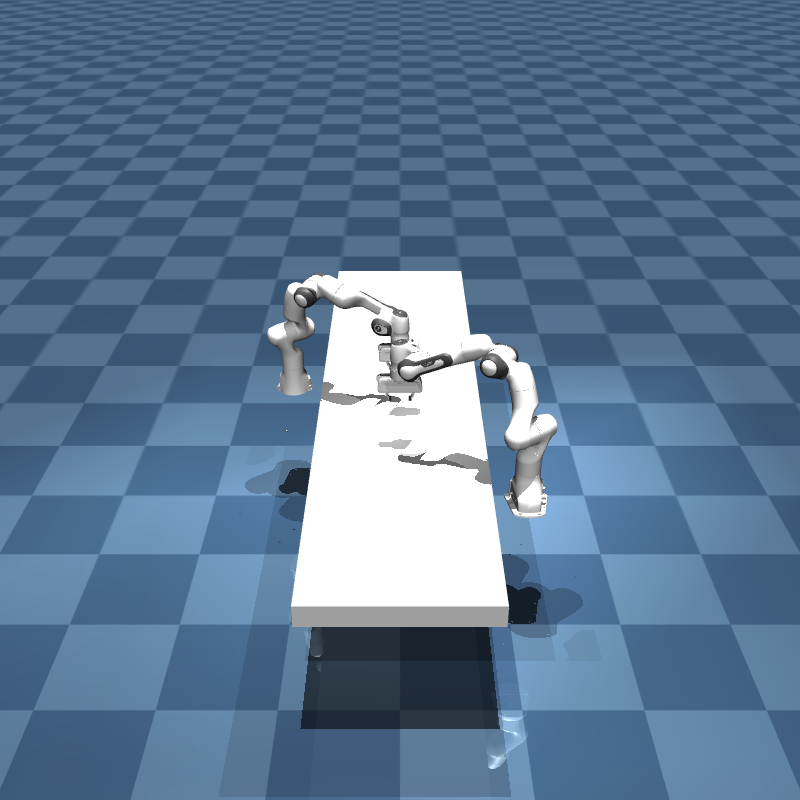

In [11]:

physics.reset(0)
physics=home_pose(physics,robots)
pixels=physics.render(width=800,height=800)
PIL.Image.fromarray(pixels) 

{'panda1': Pose(pos=(-0.50,0.50,0.50),rot=(3.14,-0.00,0.00)), 'panda2': Pose(pos=(-0.20,0.50,0.50),rot=(3.14,-0.00,0.00))}
{'panda1': (array([ 0.63447549,  0.36204225,  0.42970415, -1.69776153, -0.16486482,
        2.02395747,  1.89746479, -0.34601628]), [1, 2, 3, 4, 5, 6, 7, 0]), 'panda2': (array([ 0.59703201,  0.31977622,  0.50699328, -1.77003608, -0.17248303,
        2.04571384, -1.19445289, -0.4148582 ]), [11, 12, 13, 14, 15, 16, 17, 10])}
[-0.34601628  0.63447549  0.36204225  0.42970415 -1.69776153 -0.16486482
  2.02395747  1.89746479  0.04        0.04       -0.4148582   0.59703201
  0.31977622  0.50699328 -1.77003608 -0.17248303  2.04571384 -1.19445289
  0.04        0.04      ]


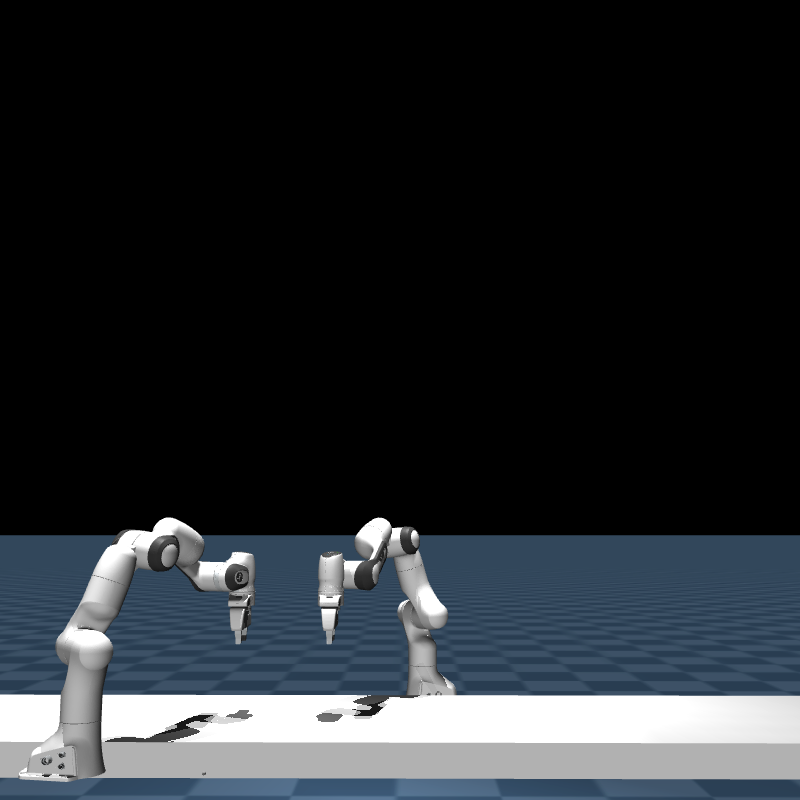

In [23]:
physics.reset(0)
planner=MultiArmRRT(physics,robots,graspable_object_names=['black_box'])
#target_ee1=Pose(np.array([ 0.05453773, -0.20000233,  0.52447919]),np.array([ 0, 1, 0, 0]))
#target_ee2=Pose(np.array([ 1.05453773, -0.20000233,  0.52447919]),np.array([ 0, 1, 0, 0]))
def get_q(theta):
    theta=theta*np.pi/180
    return np.array([0,np.sin(theta/2),0,np.cos(theta/2)])
target_ee1=Pose(np.array([ -0.5, 0.5,  0.5]),get_q(180))
target_ee2=Pose(np.array([ -0.2, 0.5,  0.5]),get_q(180))
#target_ee
ee_poses={}
ee_poses['panda1']=target_ee1
ee_poses['panda2']=target_ee2
print(ee_poses)
result=planner.inverse_kinematics_all(physics,ee_poses)
print(result)
qpos=physics.data.qpos.copy()
qpos[result['panda1'][1]]=result['panda1'][0]
qpos[result['panda2'][1]]=result['panda2'][0]
print(qpos)
with physics.reset_context():
    physics.data.qpos=qpos
    physics.data.qvel=np.zeros_like(physics.data.qvel)
    physics.step()
    pixels=physics.render(width=800,height=800,camera_id=5)
PIL.Image.fromarray(pixels)
#planner.

In [26]:
panda2.map_qpos_to_joint_ctrl(physics.data.qpos)

{'ctrl_idxs': [10, 11, 12, 13, 14, 15, 16, 9],
 'ctrl_vals': array([ 0.59703017,  0.31969344,  0.50699116, -1.77033131, -0.17248333,
         2.04637695, -1.19477207, -0.41486947])}

In [12]:
physics=home_pose(physics,robots)
goal_qposs=[physics.data.qpos.copy()]

In [13]:
goal_qposs.append(qpos)

In [104]:
del goal_qposs[3]

2


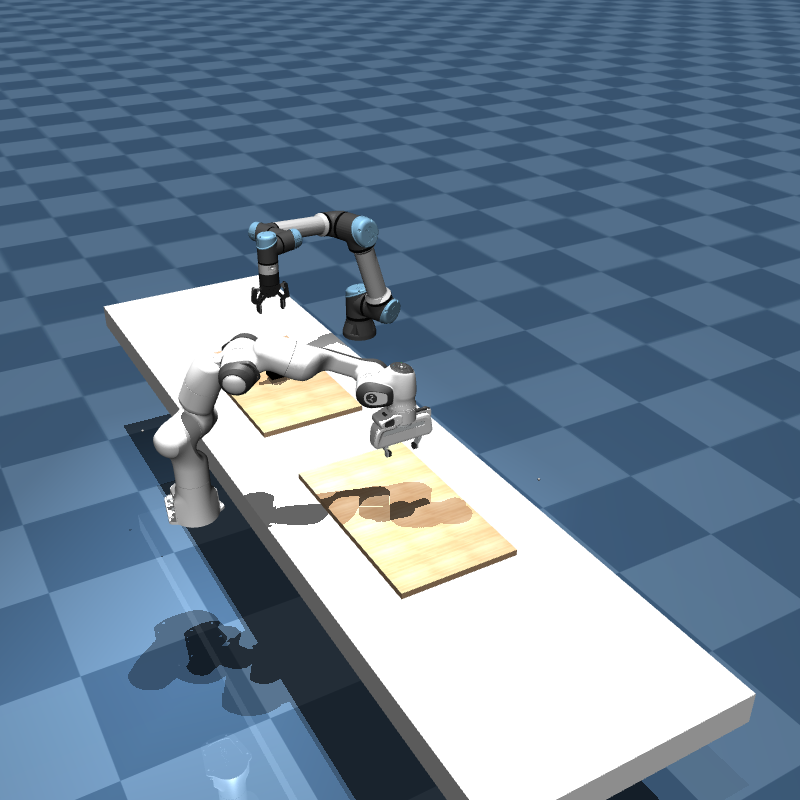

In [26]:
print(len(goal_qposs))
i=1
qpos=goal_qposs[i]
with physics.reset_context():
    physics.data.qpos=qpos
    physics.data.qvel=np.zeros_like(physics.data.qvel)
    physics.step()
    pixels=physics.render(width=800,height=800,camera_id=5)
PIL.Image.fromarray(pixels)

In [14]:
eq_ids=[0]
physics.reset()
physics=home_pose(physics,robots)
#print(planner.allow_collision_pairs(physics))
#np.concatenate((result['panda1'][0],result['panda2'][0]))
goal_qpos=physics.data.qpos.copy()
goal_qpos[result['panda1'][1]]=result['panda1'][0]
goal_qpos[result['ur5e'][1]]=result['ur5e'][0]
paths_list=[]
for i in range(len(goal_qposs)-1):
    print(i)
    paths=planner.plan(goal_qposs[i],goal_qposs[i+1],allow_grasp=True,)
    #print(paths)
    eq_ids.append(len(paths[0])+eq_ids[-1])
    paths_list+=paths[0]
    
eq_ids.append(eq_ids[-1])

print(eq_ids)

0
[0, 218, 218]


In [20]:
paths_list[0].shape

(15,)

In [15]:
actions=[([0,3],[0,0]),([0,3],[0,0]),([0,3],[0,1]),([0,3],[0,1]),([0,3],[0,1]),([0,3],[1,0]),([0,3],[1,0]),([0,3],[1,0]),([0,3],[0,0])]
print(eq_ids)
idx=eq_ids[1]
qpos_full=physics.data.qpos.copy()
    #print(qpos_full.shape)
qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
qpos_full[ur5e.joint_idxs_in_qpos]=paths_list[idx][8:16]
with physics.reset_context():
    physics.data.qpos=qpos_full
    physics.data.qvel=np.zeros_like(physics.data.qvel)
    physics.step()
    pixels=physics.render(width=800,height=800,camera_id=5)
PIL.Image.fromarray(pixels)

[0, 218, 218]


IndexError: list index out of range

In [16]:
frames = []
ctrls=[]
duration=5
framerate=20
control_rate=0.02
physics.reset(0)  # Reset state and time
physics=home_pose(physics,robots)
physics.model.eq_active[0:4]=0
physics.model.eq_active[4:8]=1

print(physics.named.model.eq_active)
#physics.model.eq_active[0:4]=0
action_id=0
while physics.data.time < duration:
# for path in paths:
    idx = int(physics.data.time/ control_rate)
    if idx>=eq_ids[action_id]:
        print(action_id)
        
        physics.model.eq_active[actions[action_id][0]]=actions[action_id][1]
        print(physics.data.time,physics.named.model.eq_active)
        action_id=min(action_id+1,len(eq_ids)-1)
    if idx >= len(paths_list):
        idx = len(paths_list) - 1
    
    # with physics.reset_context():
    t0=physics.data.time
    qpos_full=physics.data.qpos.copy()
    #print(qpos_full.shape)
    qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
    qpos_full[ur5e.joint_idxs_in_qpos]=paths_list[idx][8:15]
    #p1_full_state_qpos = [paths[idx][i] for i in range(7)] + [0. for i in range(7, 18)]
    panda1_ctrl = panda1.map_qpos_to_joint_ctrl(np.array(qpos_full))

    #p2_full_state_qpos = [0. for i in range(9)] + [paths[idx][i] for i in range(7, 14)] 
    ur5e_ctrl = ur5e.map_qpos_to_joint_ctrl(np.array(qpos_full))
    ctrl=np.zeros_like(physics.data.ctrl)
    ctrl[panda1_ctrl['ctrl_idxs']]=panda1_ctrl['ctrl_vals']
    ctrl[panda1.grasp_idx_in_ctrl]=255
    ctrl[ur5e_ctrl['ctrl_idxs']]=ur5e_ctrl['ctrl_vals']
    ctrl[ur5e.grasp_idx_in_ctrl]=0
    #ctrl=np.concatenate((panda1_ctrl['ctrl_vals'],[255],panda2_ctrl['ctrl_vals'],[255]))
    physics.data.ctrl=ctrl
    while physics.data.time-t0<control_rate:

        physics.step()
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(width=800,height=800,camera_id=5)
            frames.append(pixels)

display_video(frames, framerate)

FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
0
0.0 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
1
4.361999999999742 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
2
4.383999999999739 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom 

In [11]:
import torch
import curobo
from curobo.types.math import Pose
from curobo.types.base import TensorDeviceType
from curobo.types.robot import JointState
from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
from curobo.geom.sdf.world import CollisionCheckerType
from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere
from curobo.util_file import get_assets_path, join_path
%reload_ext autoreload

In [12]:
# cuRobo


world_config = {
    "mesh": {
        "panda1//unnamed_geom_0": {
            "pose": [10.5, 0.080, 1.6, 0.043, -0.471, 0.284, 0.834],
            "file_path": "scene/nvblox/srl_ur10_bins.obj",
        },
    },
    "cuboid": {
        "table_collision": {
            "dims": [5.0, 5.0, 0.2],  # x, y, z
            "pose": [10.0, 10.0, -0.1, 1, 0, 0, 0.0],  # x, y, z, qw, qx, qy, qz
        },
    },
}

motion_gen_config = MotionGenConfig.load_from_robot_config(
    "ur5e.yml",
    world_config,
    interpolation_dt=0.01,
)
motion_gen = MotionGen(motion_gen_config)
motion_gen.warmup()

retract_cfg = motion_gen.get_retract_config()

state = motion_gen.rollout_fn.compute_kinematics(
    JointState.from_position(retract_cfg.view(1, -1))
)

goal_pose = Pose.from_list([0.2, -0.5, 0.3, 0.0, 1.0, 0.0, 0.0])  # x, y, z, qw, qx, qy, qz
start_state = JointState.from_position(
    torch.tensor([[1.5708, -1.5708,  1.5708, -1.5708, -1.5708,  0.]]).cuda(),
    joint_names=[
        "shoulder_pan_joint",
        "shoulder_lift_joint",
        "elbow_joint",
        "wrist_1_joint",
        "wrist_2_joint",
        "wrist_3_joint",
    ],
)

result = motion_gen.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=1))
traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

Trajectory Generated:  tensor([True], device='cuda:0')


In [13]:
PANDA_CONSTANTS

{'name': 'panda',
 'all_joint_names': ['panda_base_joint',
  'joint1',
  'joint2',
  'joint3',
  'joint4',
  'joint5',
  'joint6',
  'joint7',
  'finger_joint1',
  'finger_joint2'],
 'ik_joint_names': ['panda_base_joint',
  'joint1',
  'joint2',
  'joint3',
  'joint4',
  'joint5',
  'joint6',
  'joint7'],
 'arm_joint_names': ['joint1',
  'joint2',
  'joint3',
  'joint4',
  'joint5',
  'joint6',
  'joint7'],
 'actuator_info': {'panda_base_joint': 'panda_base',
  'joint1': 'actuator1',
  'joint2': 'actuator2',
  'joint3': 'actuator3',
  'joint4': 'actuator4',
  'joint5': 'actuator5',
  'joint6': 'actuator6',
  'joint7': 'actuator7',
  'split': 'actuator8'},
 'mesh_to_geoms': {'assets/link0.stl': ['link0_collision'],
  'assets/link1.stl': ['link1_collision'],
  'assets/link2.stl': ['link2_collision'],
  'assets/link3.stl': ['link3_collision'],
  'assets/link4.stl': ['link4_collision'],
  'assets/link5_collision_0.obj': ['link5_collision_0'],
  'assets/link5_collision_1.obj': ['link5_colli

In [14]:
physics.reset()
physics.data.qpos[ur5e.joint_idxs_in_qpos]

NameError: name 'ur5e' is not defined

In [15]:
panda_qpos=[0.644818  ,  0.43834063,  0.37218651, -1.57706034, -0.16929885,1.9834506 ,  1.83842674,  1.60934804]
paths_list=[]
for i in range(traj.shape[0]):
    paths_list.append(np.array(panda_qpos+traj.position[i,:].tolist()+[0]))

NameError: name 'traj' is not defined

In [19]:
frames = []
ctrls=[]
duration=10
framerate=20
control_rate=0.02
physics.reset(0)  # Reset state and time
physics=home_pose(physics,robots)
physics.model.eq_active[0:4]=0
physics.model.eq_active[4:8]=1

print(physics.named.model.eq_active)
#physics.model.eq_active[0:4]=0
action_id=0
while physics.data.time < duration:
# for path in paths:
    idx = int(physics.data.time/ control_rate)
    if idx>=eq_ids[action_id]:
        print(action_id)
        
        physics.model.eq_active[actions[action_id][0]]=actions[action_id][1]
        print(physics.data.time,physics.named.model.eq_active)
        action_id=min(action_id+1,len(eq_ids)-1)
    if idx >= len(paths_list):
        idx = len(paths_list) - 1
    
    # with physics.reset_context():
    t0=physics.data.time
    qpos_full=physics.data.qpos.copy()
    #print(qpos_full.shape)
    qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
    qpos_full[ur5e.joint_idxs_in_qpos]=paths_list[idx][8:16]
    #p1_full_state_qpos = [paths[idx][i] for i in range(7)] + [0. for i in range(7, 18)]
    panda1_ctrl = panda1.map_qpos_to_joint_ctrl(np.array(qpos_full))

    #p2_full_state_qpos = [0. for i in range(9)] + [paths[idx][i] for i in range(7, 14)] 
    ur5e_ctrl = ur5e.map_qpos_to_joint_ctrl(np.array(qpos_full))
    ctrl=np.zeros_like(physics.data.ctrl)
    ctrl[panda1_ctrl['ctrl_idxs']]=panda1_ctrl['ctrl_vals']
    ctrl[panda1.grasp_idx_in_ctrl]=255
    ctrl[ur5e_ctrl['ctrl_idxs']]=ur5e_ctrl['ctrl_vals']
    ctrl[ur5e.grasp_idx_in_ctrl]=0
    #ctrl=np.concatenate((panda1_ctrl['ctrl_vals'],[255],panda2_ctrl['ctrl_vals'],[255]))
    physics.data.ctrl=ctrl
    while physics.data.time-t0<control_rate:

        physics.step()
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(width=800,height=800,camera_id=5)
            frames.append(pixels)

display_video(frames, framerate)

FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
0
0.0 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
1
4.361999999999742 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom [0]
2                   ur5e_top [0]
3                ur5e_bottom [0]
4 panda1//unnamed_equality_0 [1]
5   ur5e//unnamed_equality_0 [1]
6   ur5e//unnamed_equality_1 [1]
7   ur5e//unnamed_equality_2 [1]
2
4.383999999999739 FieldIndexer(eq_active):
0                 panda1_top [0]
1              panda1_bottom 

In [12]:
panda_assets_path='/home/vignesh/robot-collab_vig/rocobench/envs/assets/panda/assets'
import os
from scipy.spatial.transform import Rotation as R
# def create_curobo_world(mjcf_object,physics,body_list,robot_body_name,world_config):
#     world_config={}
#     cuboid={}
#     sphere={}
#     mesh={}
#     capsule={}
#     cylinder={}
#     for body_name in body_list:
#         current_body=mjcf_object.find('body',body_name)
#         assert current_body!=None, "body name: "+body_name+'not found'
#         kid_geoms=current_body.find_all('geom')
#         for geom in kid_geoms:
#             geom_dict={}
#             if geom.type=='box':
#                 geom_dict['dims']=list(geom.size)
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 cuboid[geom.full_indentifier]=geom_dict
#             elif geom.type=='sphere':
#                 geom_dict['radius']=float(geom.size)
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 sphere[geom.full_indentifier]=geom_dict
#             elif geom.type=='capsule':
#                 geom_dict['radius']=float(geom.size[0])
#                 geom_dict['height']=2*float(geom.size[1])
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 capsule[geom.full_indentifier]=geom_dict
#             elif geom.type=='cylinder':
#                 geom_dict['radius']=float(geom.size[0])
#                 geom_dict['height']=2*float(geom.size[1])
#                 geom_dict['pose']=list(transform_pose(physics.named.data.geom_xpos[geom.full_indentifier],physics.named.body.xpos[robot_body_name]))
#                 cylinder[geom.full_indentifier]=geom_dict
#             elif geom.type=='mesh':
#                 geom_dict['file_path']=panda_assets_path
def transform_pose_robot(object_pose,robot_pose,verbose=False):
    robot_pose_x=robot_pose[0:3].copy()
    robot_pose_q=robot_pose[[4,5,6,3]].copy()
    object_pose_x=object_pose[0:3].copy()
    object_pose_q=object_pose[[4,5,6,3]].copy()
    robot_r=R.from_quat(robot_pose_q)
    object_r=R.from_quat(object_pose_q)
    new_pose_x=robot_r.inv().apply(object_pose_x-robot_pose_x)
    new_quat=robot_r.inv()*object_r
    if verbose:
        print(object_r.as_quat(),new_quat.as_quat())
    return np.concatenate((new_pose_x,-new_quat.as_quat()[[3,0,1,2]]))
def update_curobo_world(physics,world_config,robot_name):
    #print(world_config)
    robot_pos=np.concatenate((physics.named.data.xpos[robot_name],physics.named.data.xquat[robot_name]),axis=0)
    for object_type in world_config:
        object_dict=world_config[object_type]
        for name in object_dict:
            new_xpos=physics.data.xpos[physics.named.model.geom_bodyid[name]].copy()
            #new_xpos=-physics.named.data.geom_xpos[name]+physics.named.data.geom_pos[name]
            new_quat=physics.data.xquat[physics.named.model.geom_bodyid[name]]
            xpos_robot_frame=transform_pose_robot(np.concatenate((new_xpos,new_quat),axis=0).copy(),robot_pos.copy(),verbose=False)
            object_dict[name]['pose']=xpos_robot_frame.copy()
            
            #if name=='table_collision':
                #transform_pose_robot(np.concatenate((new_xpos,new_quat),axis=0),robot_pos,verbose=True)
#update_curobo_world(physics,world_config)

In [13]:
#ur5e_assets_path = "robot/ur_description/meshes/ur5e/collision/"
panda_assets_path = "robot/franka_description/meshes/collision"


#panda_constants = append_robot_names("panda", PANDA_CONSTANTS.copy())
#ur5e_constants = append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy())
#panda_meshes = panda_constants["mesh_to_geoms"]
#ur5e_meshes = ur5e_constants["mesh_to_geoms"]
panda1_constants = append_robot_names("panda1",PANDA_CONSTANTS)
panda2_constants = append_robot_names("panda2",PANDA_CONSTANTS)
panda1_meshes=panda1_constants['mesh_to_geoms']
panda2_meshes=panda2_constants['mesh_to_geoms']
#print(panda1_meshes)
mesh_dict_panda1 = {}
mesh_dict_panda2= {}

#for key, v in panda_meshes.items():
#    mesh_dict[ panda_assets_path + '/' + key] = v

for key, v in panda2_meshes.items():
    mesh_dict_panda1[panda_assets_path + '/' + key] = v
for key, v in panda1_meshes.items():
    mesh_dict_panda2[panda_assets_path + '/' + key] = v

#print(mesh_dict['rocobench/assets/panda/assets/finger_0.obj'])

In [14]:
physics.data.xquat[physics.named.model.geom_bodyid['panda2/link1_collision']]

array([-0.29410002,  0.        ,  0.        ,  0.95577465])

In [15]:
def find_key_from_value(dictionary, value):
    for key, values in dictionary.items():
        if value in values:
            return key
    return None
def generate_world_config(physics, mesh_dict, geom_group = 3, mesh_test = False,robot_name=""):
    world_config = {"cylinder": {}, "cuboid": {}, "mesh": {}, "capsule": {}}
    
    collision_geom_idx = np.where(physics.model.geom_group == geom_group)[0]
    
    ### Looping over Robot Meshes for world_config ####
    for i in collision_geom_idx:
        
        # Access the geom model and data
        geom = physics.model.geom(i)
        geom_data = physics.data.geom(i)
        if(geom.name.split("/")[0] == robot_name):
            continue

        ## Check for different geom types ##
        if geom.type[0] ==  3: #Capsule       
            world_config["capsule"][geom.name] = { 
                                                    "radius": geom.size[0],
                                                    "base": [0,0,-geom.size[1]*2],
                                                    "tip": [0,0,geom.size[1]*2],
                                                    "pose" :np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] == 5: #Cylinder
            world_config["cylinder"][geom.name] = { 
                                                    "radius": geom.size[0],
                                                    "height": geom.size[1]*2,
                                                    "pose" : np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                    }


        
        if geom.type[0] ==  6: #Cuboid
            #
            world_config["cuboid"][geom.name] = { 
                                                "dims": list(geom.size*2),
                                                "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                                }

        if geom.type[0] ==  7: #Mesh

            #Find the key for the mesh file
            mesh_file = find_key_from_value(mesh_dict, geom.name)

            world_config["mesh"][geom.name] = { 
                                               "file_path": mesh_file,
                                               "pose": np.concatenate([geom_data.xpos, [1, 0, 0, 0]])
                                            }

    ### Testing Meshes Work ###
    if mesh_test:
        for key, value in world_config["mesh"].items():
            print(key, ":", value["file_path"])
    
    return world_config 

world_config_panda1 = generate_world_config(physics, mesh_dict_panda1, mesh_test = True,robot_name='panda1')
world_config_panda2 = generate_world_config(physics, mesh_dict_panda2, mesh_test = True,robot_name='panda2')

panda2/link0_collision : robot/franka_description/meshes/collision/assets/link0.stl
panda2/link1_collision : robot/franka_description/meshes/collision/assets/link1.stl
panda2/link2_collision : robot/franka_description/meshes/collision/assets/link2.stl
panda2/link3_collision : robot/franka_description/meshes/collision/assets/link3.stl
panda2/link4_collision : robot/franka_description/meshes/collision/assets/link4.stl
panda2/link5_collision_0 : robot/franka_description/meshes/collision/assets/link5_collision_0.obj
panda2/link5_collision_1 : robot/franka_description/meshes/collision/assets/link5_collision_1.obj
panda2/link5_collision_2 : robot/franka_description/meshes/collision/assets/link5_collision_2.obj
panda2/link6_collision : robot/franka_description/meshes/collision/assets/link6.stl
panda2/link7_collision : robot/franka_description/meshes/collision/assets/link7.stl
panda2/hand_collision : robot/franka_description/meshes/collision/assets/hand.stl
panda2/left_finger_0_collision : rob

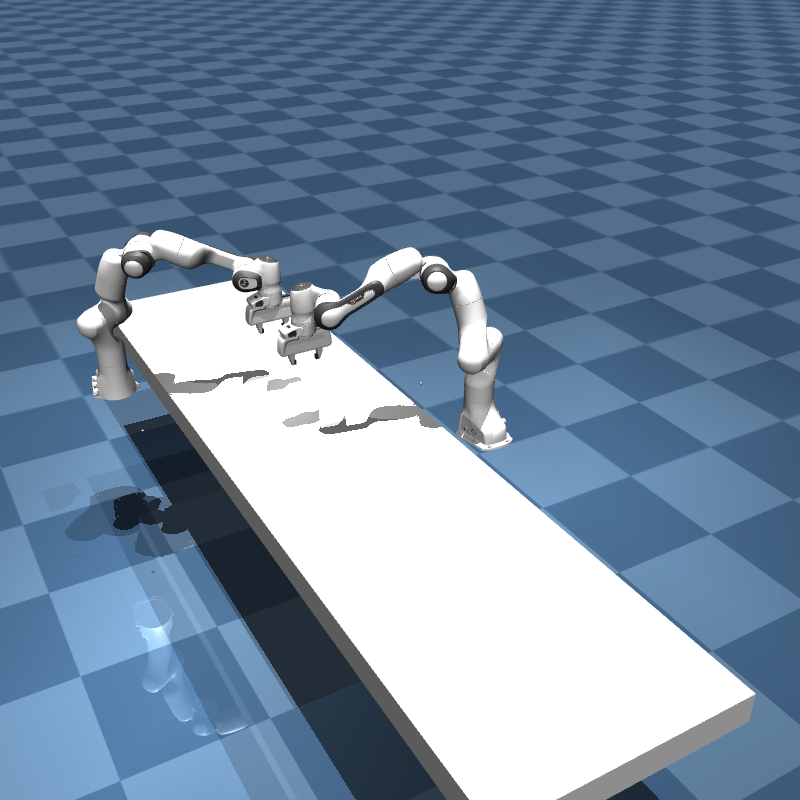

In [17]:
#physics=mjcf.Physics.from_mjcf_model(sort_task)

scene_option = MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = True # play with these values
# img = physics.render(
# camera_id='xxx', width=xxx, height=xxx,
# scene_option=scene_option), 
# render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False}, # also play with these
# ) 
#physics.
physics.reset(0)
#final_physics=mjcf.from_path('/home/vignesh/robot-collab_vig/rocobench/envs/assets/ur5e/ur5e_robotiq_full.xml')
pixels=physics.render(width=800,height=800,scene_option=scene_option,camera_id=5)

ctrl_shape=physics.data.ctrl.shape
PIL.Image.fromarray(pixels)
#np.concatenate((physics.named.data.xpos['ur5e/'],physics.named.data.xquat['ur5e/']),axis=0)

In [18]:
physics.reset(0)
update_curobo_world(physics,world_config_panda1,'panda1/')
update_curobo_world(physics,world_config_panda2,'panda2/')
#world_config_panda2
#world_config['cuboid']={'empty':{'pose':[0,0,0.2],'dims':[0.1,0.1,0.1]}}

In [29]:

mesh_name='bleh.obj'
world_config_class=WorldConfig.from_dict(world_config_panda1)
world_config_class.save_world_as_mesh(mesh_name)

In [30]:
world_config_panda2

{'cylinder': {},
 'cuboid': {'table_collision': {'dims': [3.2, 0.8, 0.1],
   'pose': array([-3.00001459e-01,  5.49999204e-01, -1.00000000e-01,  1.32679490e-06,
          -0.00000000e+00, -0.00000000e+00, -1.00000000e+00])},
  'panda1/left_fingertip_pad_collision_1': {'dims': [0.017, 0.008, 0.017],
   'pose': array([ 2.00001800e-01,  5.89978638e-01,  3.41555764e-01,  1.06530698e-04,
           1.80859534e-04, -9.99999959e-01,  1.95573579e-04])},
  'panda1/left_fingertip_pad_collision_2': {'dims': [0.006, 0.004, 0.006],
   'pose': array([ 2.00001800e-01,  5.89978638e-01,  3.41555764e-01,  1.06530698e-04,
           1.80859534e-04, -9.99999959e-01,  1.95573579e-04])},
  'panda1/left_fingertip_pad_collision_3': {'dims': [0.006, 0.004, 0.006],
   'pose': array([ 2.00001800e-01,  5.89978638e-01,  3.41555764e-01,  1.06530698e-04,
           1.80859534e-04, -9.99999959e-01,  1.95573579e-04])},
  'panda1/left_fingertip_pad_collision_4': {'dims': [0.006, 0.004, 0.007],
   'pose': array([ 2.00001

In [31]:
physics.reset(0)
#physics.step()
print(R.from_matrix(np.reshape(physics.named.data.geom_xmat['panda2/link2_collision'].copy(),(3,3))).as_quat())
print(physics.named.data.xquat['panda1/'])

[-0.19975002  0.116332    0.93757885 -0.25983204]
[1. 0. 0. 0.]


In [32]:
physics.named.model.body_quat['panda2/link2']

array([ 0.70710678, -0.70710678,  0.        ,  0.        ])

In [89]:
physics.reset(0)
update_curobo_world(physics,world_config_panda1,'panda1/')
world_model_class_1=WorldConfig.from_dict(world_config_panda1)
world_model_class_1=WorldConfig.create_obb_world(world_model_class_1)
motion_gen_config_1 = MotionGenConfig.load_from_robot_config(
    "franka_mobile.yml",
    world_model_class_1,
    interpolation_dt=0.05,
    collision_checker_type=CollisionCheckerType.PRIMITIVE,collision_activation_distance=0.01,trajopt_dt=0.25,
)
motion_gen1 = MotionGen(motion_gen_config_1)
motion_gen1.warmup(parallel_finetune=True)
#retract_cfg = motion_gen.get_retract_config()
print("warm")
update_curobo_world(physics,world_config_panda1,'panda1/')
#torch.cuda.empty_cache()
#state = motion_gen.rollout_fn.compute_kinematics(
#    JointState.from_position(retract_cfg.view(1, -1))
#)
#physics.reset()


warm


In [27]:
#physics.reset(0)
#update_curobo_world(physics,world_config_panda1,'panda1/')
#world_model_class_1=WorldConfig.from_dict(world_config_panda1)
#world_model_class_1=WorldConfig.create_obb_world(world_model_class_1)
motion_gen1.update_world(world_model_class_1)
goal_pose = Pose.from_list([0.8, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0],q_xyzw=False,tensor_args=TensorDeviceType(dtype=torch.float32))  # x, y, z, qw, qx, qy, qz
start_state = JointState.from_position(
    torch.tensor(physics.data.qpos[[0,1,2,3,4,5,6,7]],dtype=torch.float32).view(1,-1).cuda(),
    #joint_names=[
        #"shoulder_pan_joint",
        #"shoulder_lift_joint",
        #"elbow_joint",
        #"wrist_1_joint",
        #"wrist_2_joint",
        #"wrist_3_joint",
    #],
)

#result = motion_gen1.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=5,parallel_finetune=True,enable_graph=True,enable_opt=True,time_dilation_factor=0.5,finetune_attempts=1))
result = motion_gen1.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=10))
traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

Trajectory Generated:  tensor([True], device='cuda:0')


In [144]:
traj.position.shape

torch.Size([537, 8])

In [90]:
#physics.reset(1)
update_curobo_world(physics,world_config_panda2,'panda2/')

mesh_name='bleh.obj'
world_config_class=WorldConfig.from_dict(world_config_panda2)
world_model_class_2=WorldConfig.create_obb_world(world_config_class)
world_model_class_2.save_world_as_mesh(mesh_name)
motion_gen_config_2 = MotionGenConfig.load_from_robot_config(
    "franka_mobile.yml",
    world_model_class_2,
    interpolation_dt=0.05,
    collision_checker_type=CollisionCheckerType.PRIMITIVE,collision_activation_distance=0.01,trajopt_dt=0.25
)
motion_gen2 = MotionGen(motion_gen_config_2)
motion_gen2.warmup(parallel_finetune=True)
print('warm')
#retract_cfg = motion_gen.get_retract_config()
#physics.reset(0)
#torch.cuda.empty_cache()
#state = motion_gen.rollout_fn.compute_kinematics(
#    JointState.from_position(retract_cfg.view(1, -1))
#)
#physics.reset()
[  ]
goal_pose = Pose.from_list([4.5, 0.2, 0.6,0, 1,0,0 ],q_xyzw=True,tensor_args=TensorDeviceType(dtype=torch.float32))  # x, y, z, qw, qx, qy, qz
start_state = JointState.from_position(
    torch.tensor(physics.data.qpos[[10,11,12,13,14,15,16,17]].copy(),dtype=torch.float32).view(1,-1).cuda(),
    #joint_names=[
        #"shoulder_pan_joint",
        #"shoulder_lift_joint",
        #"elbow_joint",
        #"wrist_1_joint",
        #"wrist_2_joint",
        #"wrist_3_joint",
    #],
)

result = motion_gen2.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=2,parallel_finetune=True,enable_graph=True,enable_opt=True,enable_finetune_trajopt=True,time_dilation_factor=0.5))
traj = result.get_interpolated_plan()  # result.optimized_dt has the dt between timesteps
print("Trajectory Generated: ", result.success)

warm


ERROR:curobo:only single result is supported
NoneType: None


ValueError: only single result is supported

In [58]:
physics.reset(0)
physics.named.data.ctrl

FieldIndexer(ctrl):
 0             panda1/panda_base [-0.346   ]
 1              panda1/actuator1 [ 0.634   ]
 2              panda1/actuator2 [ 0.362   ]
 3              panda1/actuator3 [ 0.43    ]
 4              panda1/actuator4 [-1.7     ]
 5              panda1/actuator5 [-0.165   ]
 6              panda1/actuator6 [ 2.02    ]
 7              panda1/actuator7 [ 1.9     ]
 8 panda1/panda_gripper_actuator [ 255     ]
 9             panda2/panda_base [-0.415   ]
10              panda2/actuator1 [ 0.597   ]
11              panda2/actuator2 [ 0.32    ]
12              panda2/actuator3 [ 0.507   ]
13              panda2/actuator4 [-1.77    ]
14              panda2/actuator5 [-0.172   ]
15              panda2/actuator6 [ 2.05    ]
16              panda2/actuator7 [-1.19    ]
17 panda2/panda_gripper_actuator [ 255     ]

In [91]:
frames = []
ctrls=[]
duration=10
framerate=20
control_rate=0.05
physics.reset(0)  # Reset state and time
#physics=home_pose(physics,robots)
physics.model.eq_active[0:4]=0
physics.model.eq_active[4:8]=1

#print(physics.named.model.eq_active)
#physics.model.eq_active[0:4]=0
action_id=0
eq_ids=[0]
current_panda=panda1
t_initial=physics.data.time
while (physics.data.time-t_initial) < duration:
# for path in paths:
    idx = int((physics.data.time-t_initial)/ control_rate)
    # if idx>=eq_ids[action_id]:
    #     print(action_id)
        
    #     physics.model.eq_active[actions[action_id][0]]=actions[action_id][1]
    #     #print(physics.data.time,physics.named.model.eq_active)
    #     action_id=min(action_id+1,len(eq_ids)-1)
    if idx >= len(traj.position.cpu().numpy()):
        idx = len(traj.position.cpu().numpy()) - 1
    
    # with physics.reset_context():
    t0=physics.data.time
    qpos_full=physics.data.qpos.copy()
    #print(qpos_full.shape)
    #qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
    qpos_full[current_panda.joint_idxs_in_qpos]=list(traj.position[idx,[0,1,2,3,4,5,6,7]].cpu())
    #p1_full_state_qpos = [paths[idx][i] for i in range(7)] + [0. for i in range(7, 18)]
    #panda1_ctrl = panda1.map_qpos_to_joint_ctrl(np.array(qpos_full))

    #p2_full_state_qpos = [0. for i in range(9)] + [paths[idx][i] for i in range(7, 14)] 
    panda_ctrl = current_panda.map_qpos_to_joint_ctrl(qpos_full)
    ctrl=physics.data.ctrl.copy()
    #ctrl[panda1_ctrl['ctrl_idxs']]=panda1_ctrl['ctrl_vals']
    #ctrl[panda1.grasp_idx_in_ctrl]=255
    ctrl[panda_ctrl['ctrl_idxs']]=panda_ctrl['ctrl_vals']
    ctrl[current_panda.grasp_idx_in_ctrl]=255
    #print(ctrl)
    #break
    #ctrl=np.concatenate((panda1_ctrl['ctrl_vals'],[255],panda2_ctrl['ctrl_vals'],[255]))
    physics.data.ctrl=ctrl
    while physics.data.time-t0<control_rate:

        physics.step()
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(width=800,height=800,camera_id=5)
            frames.append(pixels)
print("Rendering")
display_video(frames, framerate)

Rendering


In [92]:
def plan_robot1(pose_list,physics):
    update_curobo_world(physics,world_config_panda1,'panda1/')
    world_model_class_1=WorldConfig.from_dict(world_config_panda1)
    world_model_class_1=WorldConfig.create_obb_world(world_model_class_1)
    motion_gen1.update_world(world_model_class_1)
    goal_pose = Pose.from_list(pose_list,q_xyzw=False,tensor_args=TensorDeviceType(dtype=torch.float32))  # x, y, z, qw, qx, qy, qz
    start_state = JointState.from_position(
    torch.tensor(physics.data.qpos[[0,1,2,3,4,5,6,7]],dtype=torch.float32).view(1,-1).cuda(),
    #joint_names=[
        #"shoulder_pan_joint",
        #"shoulder_lift_joint",
        #"elbow_joint",
        #"wrist_1_joint",
        #"wrist_2_joint",
        #"wrist_3_joint",
    #],
    )

    result = motion_gen1.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=3,parallel_finetune=True,enable_graph=True,enable_opt=True,time_dilation_factor=0.3,finetune_attempts=1,partial_ik_opt=True))
    traj = result.get_interpolated_plan()  
    if traj is None:
        raise Exception('Plan bad')
    print(result.success)
    return traj
def plan_robot2(pose_list,physics):
    update_curobo_world(physics,world_config_panda2,'panda2/')
    world_config_class=WorldConfig.from_dict(world_config_panda2)
    world_model_class_2=WorldConfig.create_obb_world(world_config_class)
    motion_gen2.update_world(world_model_class_2)
    #world_model_class_2.save_world_as_mesh(mesh_name)
    goal_pose = Pose.from_list(pose_list,q_xyzw=True,tensor_args=TensorDeviceType(dtype=torch.float32))  # x, y, z, qw, qx, qy, qz
    start_state = JointState.from_position(
    torch.tensor(physics.data.qpos[[10,11,12,13,14,15,16,17]].copy(),dtype=torch.float32).view(1,-1).cuda(),
    #joint_names=[
        #"shoulder_pan_joint",
        #"shoulder_lift_joint",
        #"elbow_joint",
        #"wrist_1_joint",
        #"wrist_2_joint",
        #"wrist_3_joint",
    #],
    )

    result = motion_gen2.plan_single(start_state, goal_pose, MotionGenPlanConfig(max_attempts=3,parallel_finetune=True,enable_graph=True,enable_opt=True,enable_finetune_trajopt=True,time_dilation_factor=0.3,partial_ik_opt=True))
    traj = result.get_interpolated_plan()
    if traj is None:
        raise Exception('Plan bad')
    print(result.success)
    return traj

In [95]:
frames = []
ctrls=[]
duration=20
framerate=20
control_rate=0.05
physics.reset(0)  # Reset state and time
#physics=home_pose(physics,robots)
physics.model.eq_active[0:4]=0
physics.model.eq_active[4:8]=1

#print(physics.named.model.eq_active)
#physics.model.eq_active[0:4]=0
action_id=0
eq_ids=[0]
current_panda_number=1
t_initial=physics.data.time
while (physics.data.time) < duration:
    t_initial=physics.data.time
    if current_panda_number==1:
        print(t_initial,'In panda1')
        traj=plan_robot1([1, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0],physics)
        current_panda=panda1
        current_panda_number=2
    else:
        print(t_initial,'In panda2')
        traj=plan_robot2([1, 0.4, 0.6,0, 1,0,0 ],physics)
        current_panda=panda2
        current_panda_number=1
    
    while (physics.data.time-t_initial) < 0.5:
        idx = int((physics.data.time-t_initial)/ control_rate)
        # if idx>=eq_ids[action_id]:
        #     print(action_id)
            
        #     physics.model.eq_active[actions[action_id][0]]=actions[action_id][1]
        #     #print(physics.data.time,physics.named.model.eq_active)
        #     action_id=min(action_id+1,len(eq_ids)-1)
        if idx >= len(traj.position.cpu().numpy()):
            idx = len(traj.position.cpu().numpy()) - 1
        
        # with physics.reset_context():
        t0=physics.data.time
        qpos_full=physics.data.qpos.copy()
        #print(qpos_full.shape)
        #qpos_full[panda1.joint_idxs_in_qpos]=paths_list[idx][0:8]
        qpos_full[current_panda.joint_idxs_in_qpos]=list(traj.position[idx,[0,1,2,3,4,5,6,7]].cpu())
        #p1_full_state_qpos = [paths[idx][i] for i in range(7)] + [0. for i in range(7, 18)]
        #panda1_ctrl = panda1.map_qpos_to_joint_ctrl(np.array(qpos_full))

        #p2_full_state_qpos = [0. for i in range(9)] + [paths[idx][i] for i in range(7, 14)] 
        panda_ctrl = current_panda.map_qpos_to_joint_ctrl(qpos_full)
        ctrl=physics.data.ctrl.copy()
        #ctrl[panda1_ctrl['ctrl_idxs']]=panda1_ctrl['ctrl_vals']
        #ctrl[panda1.grasp_idx_in_ctrl]=255
        ctrl[panda_ctrl['ctrl_idxs']]=panda_ctrl['ctrl_vals']
        ctrl[current_panda.grasp_idx_in_ctrl]=255
        #print(ctrl)
        #break
        #ctrl=np.concatenate((panda1_ctrl['ctrl_vals'],[255],panda2_ctrl['ctrl_vals'],[255]))
        physics.data.ctrl=ctrl
        while physics.data.time-t0<control_rate:

            physics.step()
            if len(frames) < physics.data.time * framerate:
                pixels = physics.render(width=800,height=800,camera_id=5)
                frames.append(pixels)
print("Rendering")
display_video(frames, framerate)

0.0 In panda1


tensor([True], device='cuda:0')
0.5020000000000003 In panda2


tensor([True], device='cuda:0')
1.0040000000000007 In panda1


tensor([True], device='cuda:0')
1.5040000000000011 In panda2


tensor([True], device='cuda:0')
2.0060000000000007 In panda1


tensor([True], device='cuda:0')
2.5259999999999434 In panda2


tensor([True], device='cuda:0')
3.045999999999886 In panda1


tensor([True], device='cuda:0')
3.565999999999829 In panda2


tensor([True], device='cuda:0')
4.085999999999772 In panda1


tensor([True], device='cuda:0')
4.605999999999715 In panda2


tensor([True], device='cuda:0')
5.1259999999996575 In panda1


tensor([True], device='cuda:0')
5.6459999999996 In panda2


tensor([True], device='cuda:0')
6.165999999999543 In panda1


tensor([True], device='cuda:0')
6.685999999999486 In panda2


tensor([True], device='cuda:0')
7.205999999999428 In panda1


tensor([True], device='cuda:0')
7.725999999999371 In panda2


tensor([True], device='cuda:0')
8.23599999999942 In panda1


tensor([True], device='cuda:0')
8.735999999999587 In panda2


tensor([True], device='cuda:0')
9.235999999999754 In panda1


tensor([True], device='cuda:0')
9.73599999999992 In panda2


tensor([True], device='cuda:0')
10.236000000000088 In panda1


tensor([True], device='cuda:0')
10.736000000000255 In panda2


tensor([True], device='cuda:0')
11.236000000000422 In panda1


tensor([True], device='cuda:0')
11.736000000000589 In panda2


tensor([True], device='cuda:0')
12.236000000000756 In panda1


tensor([True], device='cuda:0')
12.736000000000923 In panda2


tensor([True], device='cuda:0')
13.23600000000109 In panda1


tensor([True], device='cuda:0')
13.736000000001257 In panda2


tensor([True], device='cuda:0')
14.236000000001424 In panda1


tensor([True], device='cuda:0')
14.73600000000159 In panda2


tensor([True], device='cuda:0')
15.236000000001757 In panda1


tensor([True], device='cuda:0')
15.736000000001924 In panda2


tensor([True], device='cuda:0')
16.246000000001874 In panda1


tensor([True], device='cuda:0')
16.766000000001586 In panda2


tensor([True], device='cuda:0')
17.286000000001298 In panda1


Exception: Plan bad

In [96]:
display_video(frames, framerate)